In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append('../utils')
sys.path.append('../dFC')
import widefield_utils
import connectivity_measures

In [6]:
mask = np.load(r"/home/k21208334/calcium_analyses/data/dowsampled_tight_mask.npy")
good_indices = np.ravel(mask)

In [4]:
h=300
w=304
H=50 # this is the size of downsampling. We have to find a better way to do this
W=51
start = 0
end = 25000

names = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]

n_comp = 10 # i choose this n of components because it's the most convincing

In [43]:
signals = np.load('/home/k21208334/calcium_analyses/data/ICA/signals_n=' + str(n_comp) + '.npy')
comps = np.load('/home/k21208334/calcium_analyses/data/ICA/components_n=' + str(n_comp) + '.npy')

In [ ]:
# For each component, I compare each ICA component absolute amplitude and I do walking vs non walking

In [34]:
# create walking timeseries note the cool python command I use:
all_walking = np.concatenate([np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy') for name in names+names_knock])

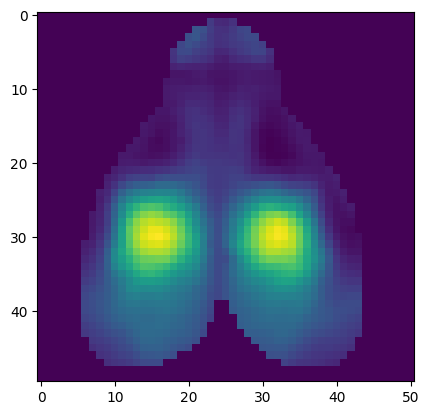

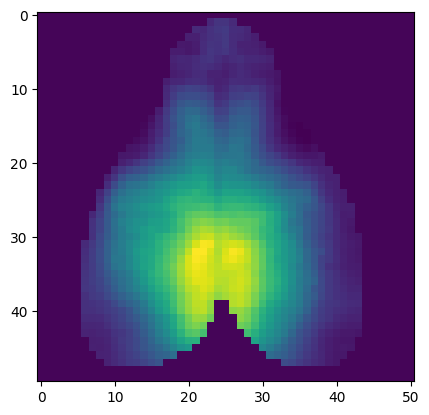

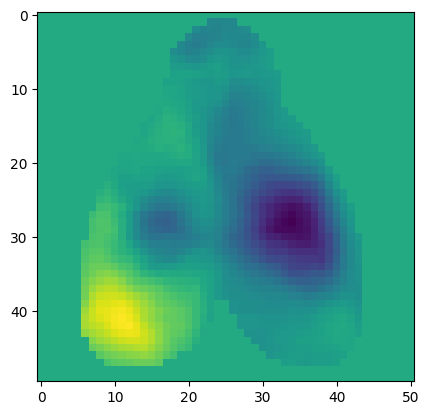

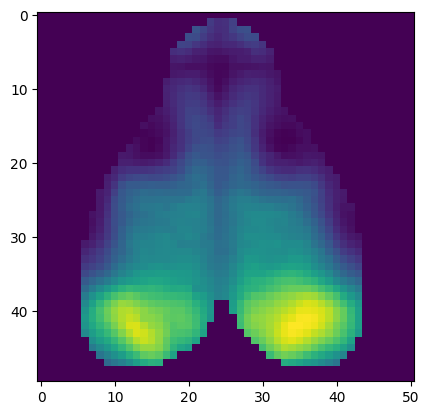

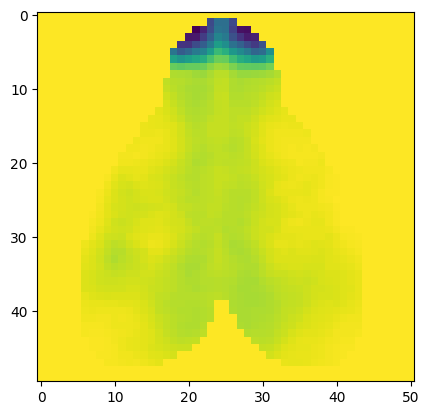

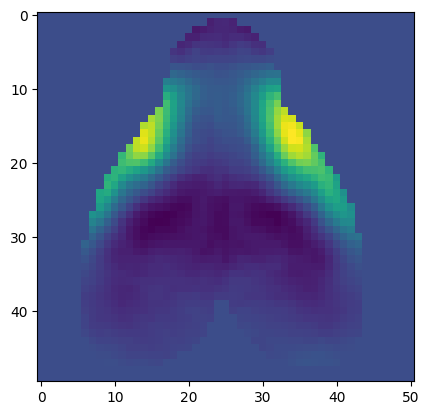

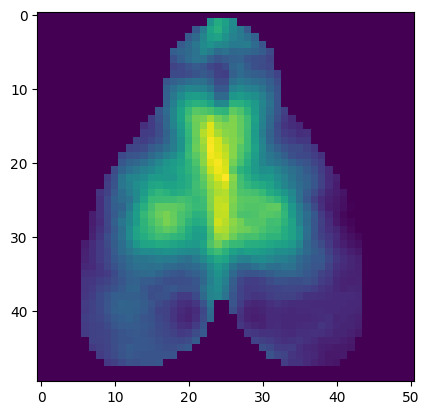

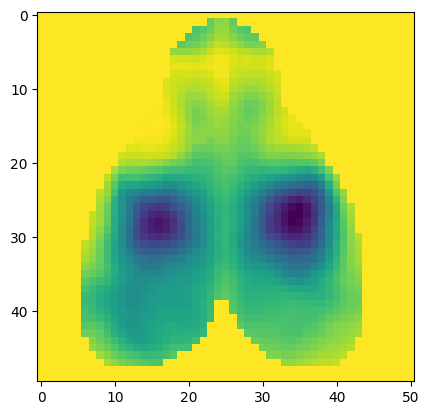

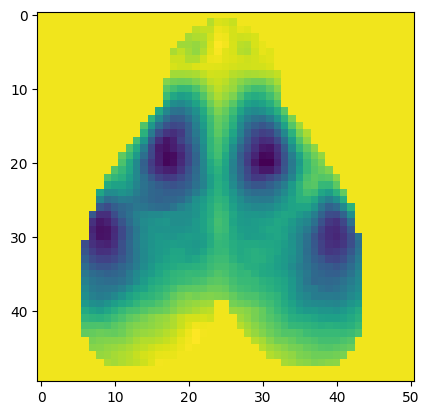

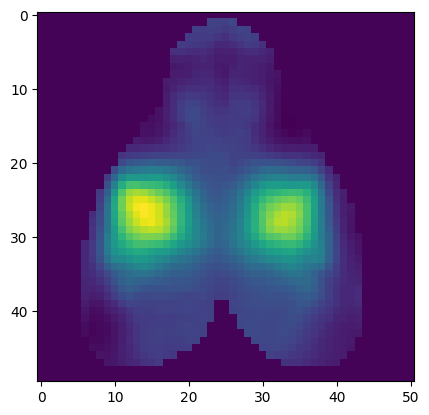

In [47]:
len = signals.shape[0]

for i in range(n_comp):
    connectivity_measures.show_array(comps[:,i],H,W,good_indices,comps[:,i].min(),comps[:,i].max())
    #abs_sign = 

In [21]:
test1 = np.abs(signals[0:149999,1])
test2 = np.abs(signals[150000:299999,1])

In [22]:
scipy.stats.wilcoxon(test1,test2)

WilcoxonResult(statistic=4185169625.0, pvalue=0.0)

In [46]:
comps

array([[ 0.00492255,  0.00159265, -0.00249275, ..., -0.00849524,
        -0.00098993,  0.00652222],
       [ 0.00341551,  0.00215604, -0.00262782, ..., -0.00685596,
        -0.0003522 ,  0.00647701],
       [ 0.00325622,  0.00217424, -0.00245089, ..., -0.00668347,
        -0.00044342,  0.00628038],
       ...,
       [ 0.00378228,  0.00146232, -0.00085633, ..., -0.00483849,
        -0.00181535,  0.00294441],
       [ 0.00341945,  0.00095966, -0.00090104, ..., -0.0046879 ,
        -0.00169838,  0.00256848],
       [ 0.00316799,  0.00078874, -0.00073696, ..., -0.00436504,
        -0.00166752,  0.00227537]])